# ICBC话务数据分析
Weina Ma - January 18, 2018

## 工作进展
* 分析一天数据2016-08-01，并发现一些可疑号码
* 总结可疑pattern

## 计划
* 继续数据挖掘，希望发现更多可疑pattern
* 使用这些可疑号码作为seed，尝试聚类算法
* profiling

## 发现
* 座机或IP电话比手机拨打频次更高
* 针对不同中继的呼入时长分析
    * 每个中继有不同数量，通话时间很长的outlier，这些outlier可能是可疑号码
    * 有些中继的通话时长都很短，需要进一步确认是与业务相关，还是可疑呼入集中在这个中继
* 同一号码，连续两次通话间隔一分钟，每次通话超过半小时，如何做到？重复记录？
* 凌晨1:00到5:00频繁拨打电话，通话时长为0，或者较短，全部为6的整数倍，比如6，12，18，24，36秒...
* 工作时间频繁拨打电话，通话时长为0，或者有长有短，全部为6的整数倍，比如6秒到210秒，或者6秒到1608秒，时长分布较均匀
* 一天内某个时间段集中频繁拨打电话，且通话时间极短。比如半小时内通话80次，30+次通话0秒，40+次通话12秒
* 一组可疑电话行为模式相似，且号码貌似有规律。比如一组联通号码（6个），每个号码都集中一段时间内频繁拨打电话（时间重叠或错开），通话时间短，号码都是“186973”或者“186381”开头。
* 同一号码频繁访问不同地域中继。比如，电信某号码一天拨打电话100次，分别通过18个不同地域中继，如青海，上海，北京，宁夏，青岛，大连，陕西，山西等

==========================================
### 1. Load data (1158067 rows × 24 columns)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import missingno as msno
%matplotlib inline

pd.options.display.float_format = '{:.0f}'.format

# 2016-08-01.csv is from 2016-08-01.xml
df=pd.read_csv("/vagrant/gong_hang/csv/2016-08-01.csv", encoding='utf-8')
# list 5 rows in 2016-08-01.csv
df.head()

,ID,SRC_ADD,CALLING_NUM,VDN,DIALED_NUM,DURATION,CALLING_DATE,CALLING_TIME,COND_CODE,IN_TRK_CODE,...,CIRCUIT_TYPE,CALLERLOC,CALL_NUM,CALL_TYPE,CHARGE_RULE_ID,COST,CALL_DATE,CRE_DATE,MAKER_NAME,ADDRESS
0,818232380,80.14.12.8,18341708013,74062,36680,66,80116,516,9,4892,...,2,辽宁营口,1,1,0,0,2016/8/1 5:16:00,2016/8/1 5:17:05,联通,nan
1,818232381,80.14.12.8,13941548467,74062,74062,0,80116,516,G,4892,...,2,辽宁丹东,1,1,0,0,2016/8/1 5:16:00,2016/8/1 5:17:05,联通,nan
2,818232382,80.14.12.8,15565260206,74073,74073,0,80116,516,G,4886,...,2,河南新乡,1,1,0,0,2016/8/1 5:16:00,2016/8/1 5:17:05,联通,nan
3,818232383,80.14.12.8,18645888141,74058,74058,0,80116,516,G,4821,...,2,黑龙江伊春,1,1,0,0,2016/8/1 5:16:00,2016/8/1 5:17:05,联通,nan
4,818232384,80.14.12.8,15266271069,74064,74064,0,80116,516,G,4870,...,2,山东枣庄,1,1,0,0,2016/8/1 5:16:00,2016/8/1 5:17:05,联通,nan


In [3]:
# (number_of_rows, number_of_columns)
df.shape

(1514999, 24)

### 2. Filter data
* 分析通话为主叫
* 号码为手机、座机、IP电话
* 关注的呼入中继（  IN_TRK_CODE  ）号
* 排除6个手机号码，这6个号码其它系统进行工行拨测使用号码

In [4]:
# filter dailed out & 95588 & area_code + 95588
df = df[(df['CALL_TYPE'] == 1) & \
        (df['CALLING_NUM']/1000000 >= 1) & ((df['CALLING_NUM']%100000 != 95588) | (df['CALLING_NUM']/100000000 >= 1))]

# filter test numbers
df = df[df['CALLING_NUM'].isin([18210261957, 18210261795, 17343195721, \
                               17718332497, 17718332497, 13263105230, 13263103918]) == False]

# filter IN_TRK_CODE
df = df[df['IN_TRK_CODE'].isin([4860,4881,4815,4816,4834,4873,4878,4899,4820,4862,\
                                4849,4850,4828,4827,4858,4859,4840,4829,4848,4830,\
                                4831,4832,4833,4847,4854,4705,4706,4707,4708,4709,\
                                4710,4711,4712,4713,4714,4855,4715,4716,4717,4718,\
                                4719,4720,4721,4722,4723,4724,4856,4725,4726,4727,\
                                4728,4729,4730,4731,4732,4733,4857,4700,4701,4702,\
                                4703,4704,4872,4804,4894,4801,4898,4821,4805,4897,\
                                4806,4802,4892,4893,4890,4861,4870,4826,4885,4886,\
                                4810,4811,4852,4853,4880,4879,4807,4823,4876,4877,\
                                4808,4803,4812])]

df.shape

(1158067, 24)

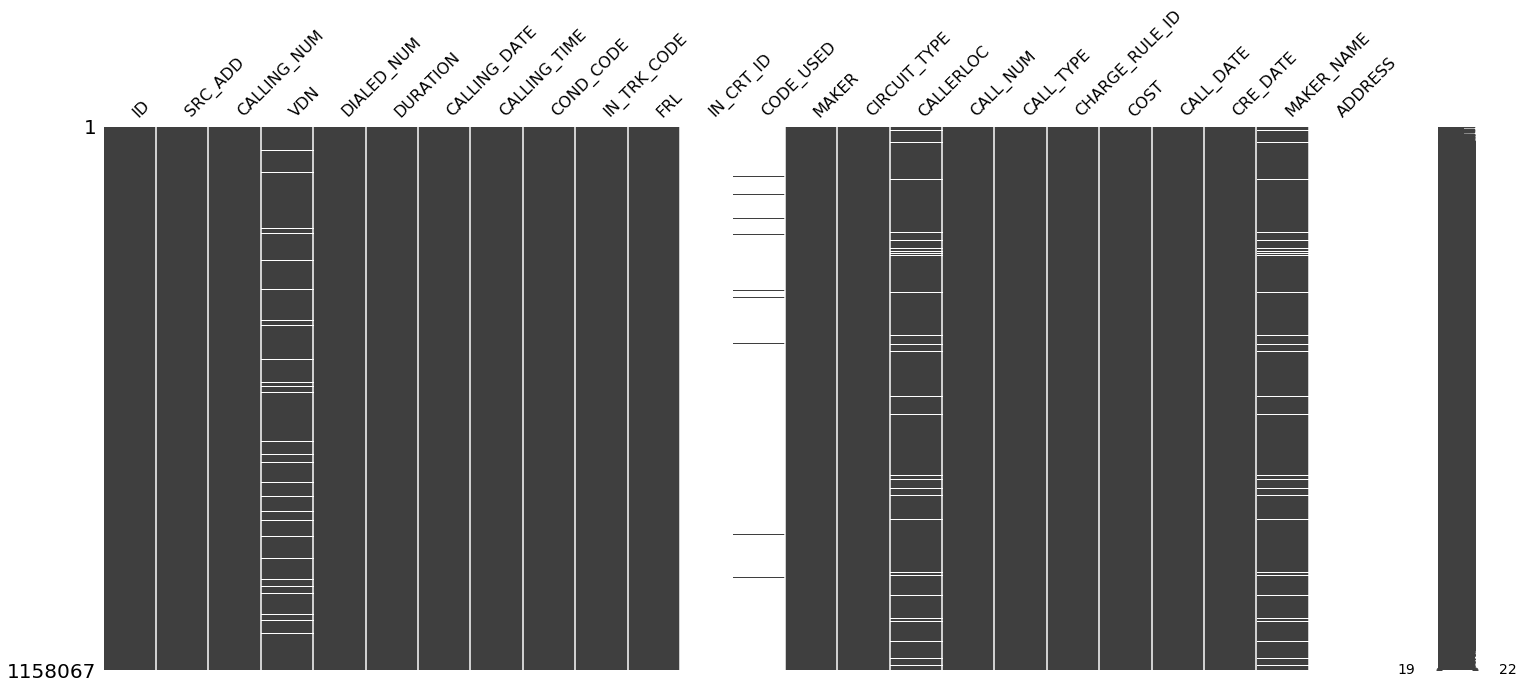

In [5]:
# missing data visualization
msno.matrix(df)

In [6]:
# Missing values
df.isnull().sum()

ID                      0
SRC_ADD                 0
CALLING_NUM             0
VDN                 53210
DIALED_NUM              0
DURATION                0
CALLING_DATE            0
CALLING_TIME            0
COND_CODE               0
IN_TRK_CODE             0
FRL                     0
IN_CRT_ID         1158067
CODE_USED         1146237
MAKER                   0
CIRCUIT_TYPE            0
CALLERLOC           42522
CALL_NUM                0
CALL_TYPE               0
CHARGE_RULE_ID          0
COST                    0
CALL_DATE               0
CRE_DATE                0
MAKER_NAME          42522
ADDRESS           1158067
dtype: int64

### 3. 号码归属运营商分析
* 移动（50%）
* 联通（21%）
* 电信（17%）
* 其他（12%）

** 分析每个类别top10号码，发现座机或IP电话比手机拨打频次更高 **

In [7]:
df['HOURS'] = df['CALLING_TIME'].apply(lambda x:abs(x) / 100 )

#移动
df_y = df[(df['CALLING_NUM']/100000000).astype(int).isin([134,135,136,137,138,139,147,150,151,152,157,159,182,183,187,188,172,178,184,198,148])]
print "=====China mobile："
print df_y.shape
print len(df_y["CALLING_NUM"].unique())
print df_y["CALLING_NUM"].value_counts().nlargest(10)
#联通
df_l = df[(df['CALLING_NUM']/100000000).astype(int).isin([130,131,132,145,155,156,186,171,175,176,185,166,146])]
print "=====China Unicom:" 
print df_l.shape
print len(df_l["CALLING_NUM"].unique())
print df_l["CALLING_NUM"].value_counts().nlargest(10)
#电信
df_d = df[(df['CALLING_NUM']/100000000).astype(int).isin([133,153,180,189,149,173,177,181,199])]
print "=====China Telecommunications:"
print df_d.shape
print len(df_d["CALLING_NUM"].unique())
print df_d["CALLING_NUM"].value_counts().nlargest(10)
#others
print "=====Others:"
df_g = df[(df['CALLING_NUM']/100000000).astype(int).isin([134,135,136,137,138,139,147,150,151,152,157,159,182,183,187,188,172,178,184,198,148,\
                                                         130,131,132,145,155,156,186,171,175,176,185,166,146,\
                                                         133,153,180,189,149,173,177,181,199]) == False]
print df_g.shape
print len(df_g["CALLING_NUM"].unique())
print df_g["CALLING_NUM"].value_counts().nlargest(10)

=====China mobile：
(578241, 25)
192303
18703830954    131
15225198120     75
13910548519     68
15192015785     66
13804520492     63
15266708626     62
13780612018     56
13664078521     51
13579306724     49
13841915958     48
Name: CALLING_NUM, dtype: int64
=====China Unicom:
(246370, 25)
78248
18693015658    115
18697333574     85
18638167274     78
18697332094     76
18638175094     73
18697323604     65
13167632999     60
15645816866     53
18695830824     52
15642229818     52
Name: CALLING_NUM, dtype: int64
=====China Telecommunications:
(187559, 25)
57807
13328108463    100
13353721221     86
13386365771     62
17719075381     50
18163404369     48
15332956425     46
18195002339     43
18166805787     42
13304689196     42
18953659498     42
Name: CALLING_NUM, dtype: int64
=====Others:
(145897, 25)
43727
95588000       1054
53285763392     931
5305696229      784
6317381531      473
37160959885     294
41183604731     208
28555222        206
53186912195     180
4122598312     

### 4. 不同中继的呼入时长分析
* 每个中继有不同数量，不同呼入时长的outlier，这些outlier是可疑号码
* 有些中继的通话时长都很短，需要进一步确认是与业务相关，还是可疑呼入集中在这个中继

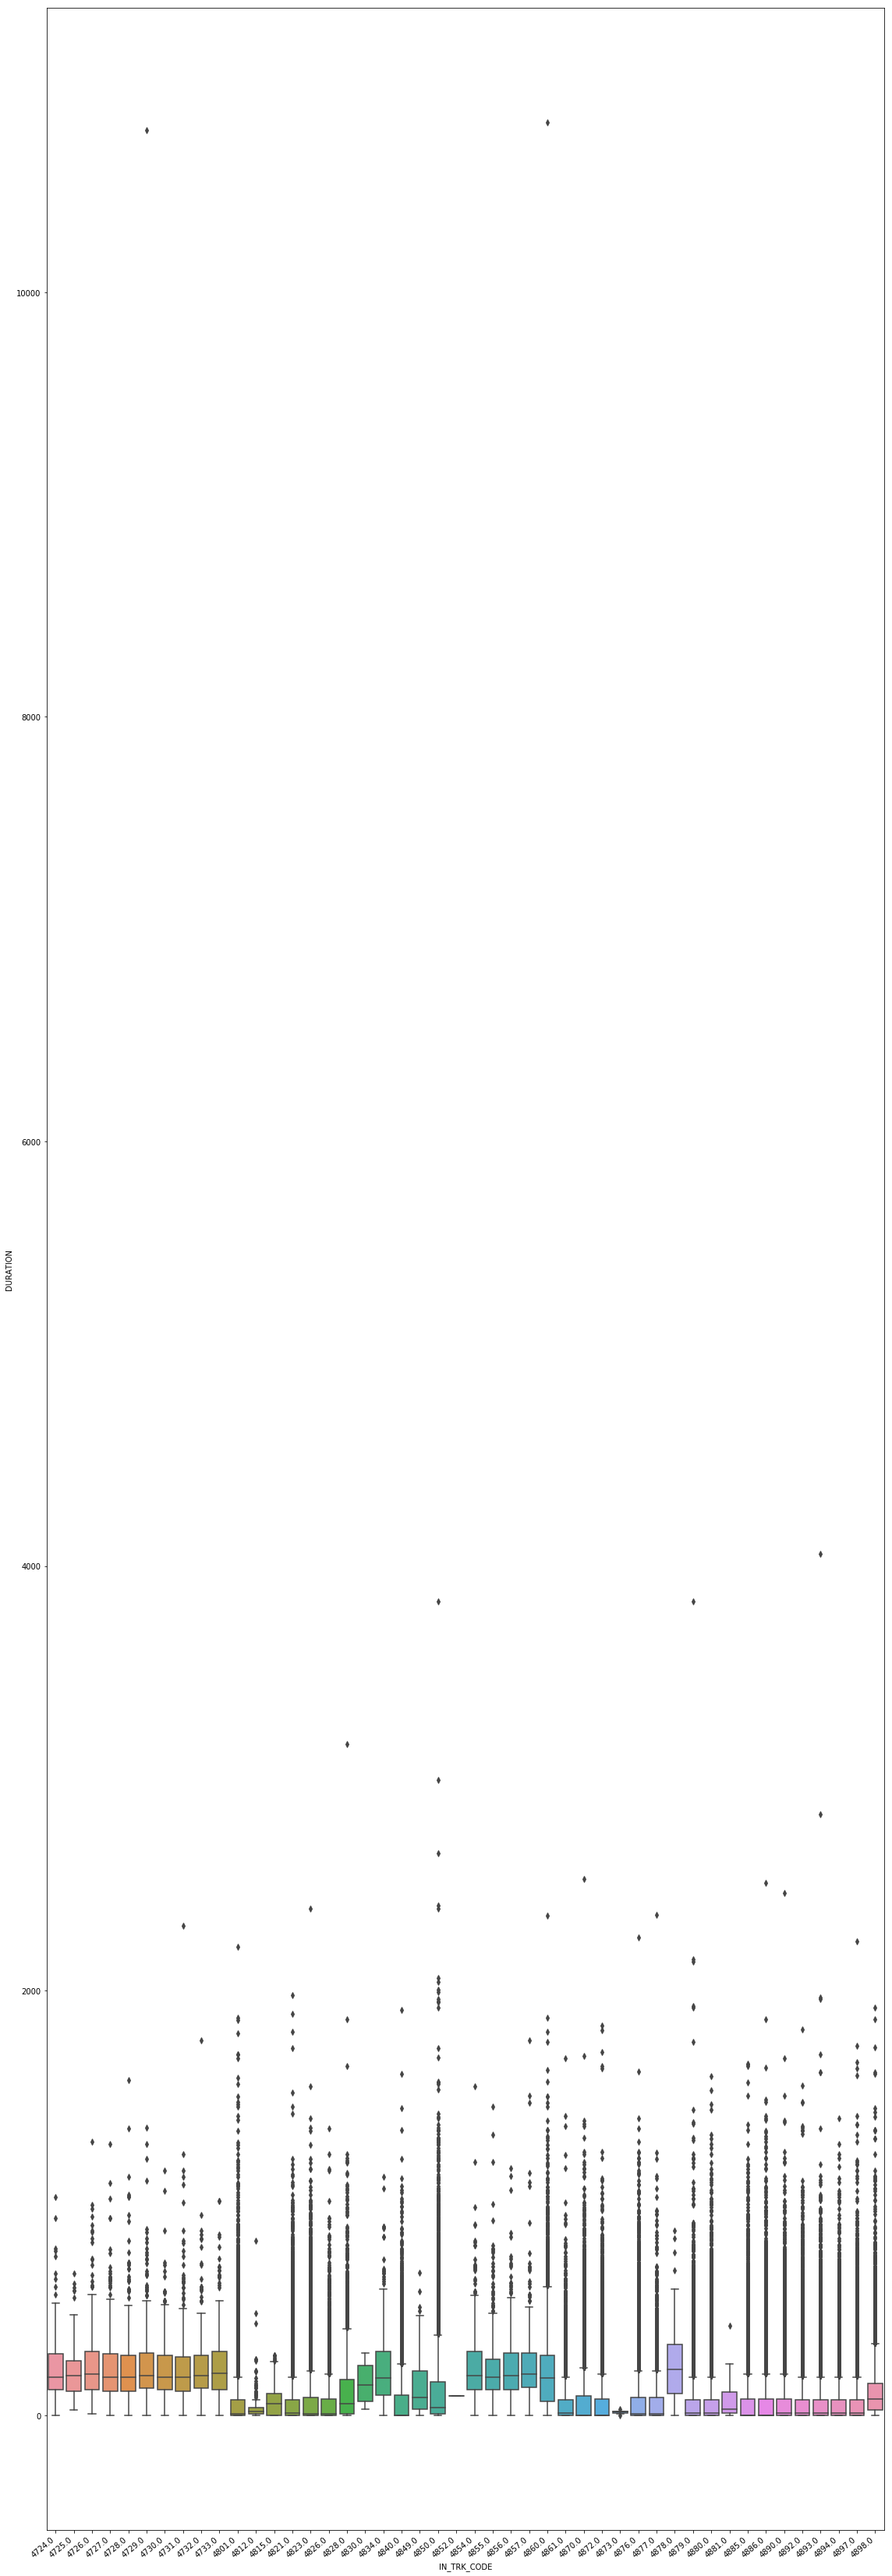

In [8]:
plt.pyplot.figure(figsize=(16,46))
ax = sns.boxplot(x="IN_TRK_CODE", y="DURATION", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

### 5. 连续长通话
同一号码，连续两次通话间隔一分钟，每次通话超过半小时，如何做到？重复记录？

(4763, 25)
37155179951    6
37155959852    5
28555222       5
18611890520    4
2268289566     4
15823763777    4
3187515183     4
18603509122    4
13828779213    4
66410055       4
Name: CALLING_NUM, dtype: int64


,ID,SRC_ADD,CALLING_NUM,VDN,DIALED_NUM,DURATION,CALLING_DATE,CALLING_TIME,COND_CODE,IN_TRK_CODE,...,CALLERLOC,CALL_NUM,CALL_TYPE,CHARGE_RULE_ID,COST,CALL_DATE,CRE_DATE,MAKER_NAME,ADDRESS,HOURS
1443087,819624096,80.14.12.8,18611890520,76304,76304,0,80116,2119,9,4860,...,北京,2,1,0,0,2016/8/1 21:19:00,2016/8/1 21:19:44,联通,nan,21
1451868,819663768,80.14.12.8,18611890520,76304,76304,2352,80116,2159,9,4860,...,北京,2,1,0,0,2016/8/1 21:59:00,2016/8/1 21:59:13,联通,nan,21
1452750,819663735,80.14.44.18,18611890520,74203,4848,2304,80116,2158,9,4731,...,NaN,0,1,0,0,2016/8/1 21:58:00,2016/8/1 21:59:13,NaN,nan,21
1465019,819675087,80.14.12.8,18611890520,74203,74203,36,80116,2211,9,4732,...,NaN,0,1,0,0,2016/8/1 22:11:00,2016/8/1 22:12:11,NaN,nan,22
1465059,819675125,80.14.44.18,18611890520,76304,76304,72,80116,2211,9,4860,...,北京,2,1,0,0,2016/8/1 22:11:00,2016/8/1 22:12:11,联通,nan,22
1506478,819686929,80.14.44.18,18611890520,76304,76304,900,80116,2227,9,4860,...,北京,2,1,0,0,2016/8/1 22:27:00,2016/8/1 22:27:41,联通,nan,22
1506481,819686932,80.14.12.8,18611890520,74203,74203,870,80116,2227,9,4726,...,NaN,0,1,0,0,2016/8/1 22:27:00,2016/8/1 22:27:41,NaN,nan,22


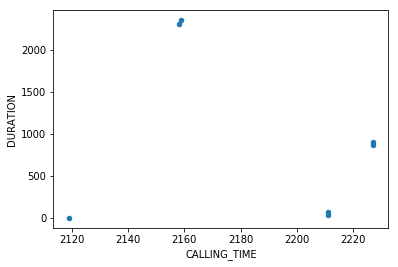

In [58]:
df_0 = df[df["DURATION"] > 600]
print df_0.shape
print df_0["CALLING_NUM"].value_counts().nlargest(10)

df_01 = df[df['CALLING_NUM'] == 18611890520]
df_01.plot(kind='scatter', x='CALLING_TIME', y='DURATION');
df_01.head(10)

### 6. 国外呼入电话
考虑时差，通话时长，拨打频次，加拿大呼入电话当天看起来正常。
因为国外电话相对较少，可以加入更多天的数据，分析不同时差国家呼入电话。

In [80]:
df_f = df[(df['IN_TRK_CODE'] == 4830) & (df['SRC_ADD'] == "80.14.44.18")]
print df_f.shape
df_f.head(6)

(6, 25)


,ID,SRC_ADD,CALLING_NUM,VDN,DIALED_NUM,DURATION,CALLING_DATE,CALLING_TIME,COND_CODE,IN_TRK_CODE,...,CALLERLOC,CALL_NUM,CALL_TYPE,CHARGE_RULE_ID,COST,CALL_DATE,CRE_DATE,MAKER_NAME,ADDRESS,HOURS
1452824,819663810,80.14.44.18,6478871788,76010,45119,180,80116,2159,C,4830,...,NaN,0,1,0,0,2016/8/1 21:59:00,2016/8/1 21:59:13,NaN,nan,21
1458536,819669521,80.14.44.18,4168030734,76010,45172,102,80116,2205,9,4830,...,NaN,0,1,0,0,2016/8/1 22:05:00,2016/8/1 22:05:43,NaN,nan,22
1463022,819720810,80.14.44.18,4165007048,76010,45114,54,80116,2330,9,4830,...,NaN,0,1,0,0,2016/8/1 23:30:00,2016/8/1 23:31:08,NaN,nan,23
1469282,819723166,80.14.44.18,4165007048,76010,45089,294,80116,2337,9,4830,...,NaN,0,1,0,0,2016/8/1 23:37:00,2016/8/1 23:38:07,NaN,nan,23
1507289,819688964,80.14.44.18,9025371826,76010,45009,252,80116,2230,9,4830,...,NaN,0,1,0,0,2016/8/1 22:30:00,2016/8/1 22:30:40,NaN,nan,22
1511576,819725913,80.14.44.18,6478689665,76010,45043,30,80116,2346,9,4830,...,NaN,0,1,0,0,2016/8/1 23:46:00,2016/8/1 23:46:37,NaN,nan,23


### 7. 半夜频繁拨打电话，时长较短
凌晨1:00到5:00频繁拨打电话，通话时长为0，或者较短，全部为6的整数倍，比如6，12，18，24，36秒...

(12933, 26)
5204
41183604731    152
53285763392    107
9162512824      74
6317381531      71
5305696229      67
18842615677     26
37160959885     22
2988620359      21
13565939129     20
15535154599     20
Name: CALLING_NUM, dtype: int64


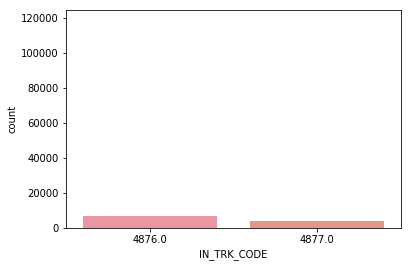

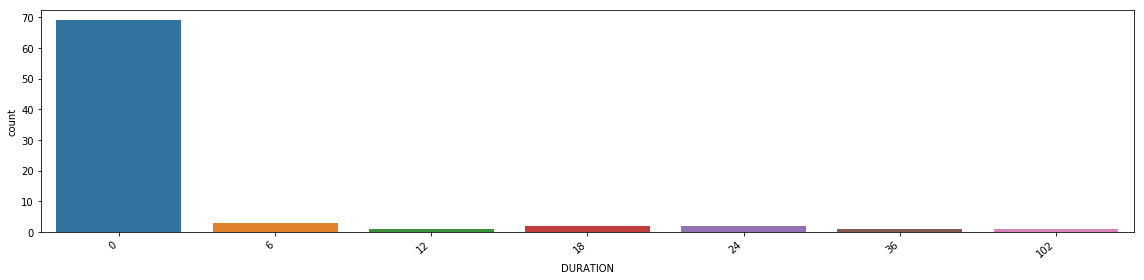

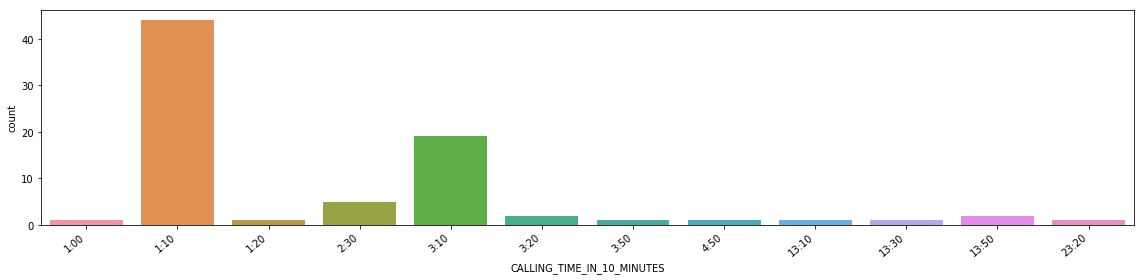

In [117]:
sns.countplot(df["HOURS"].values)

df_night = df[(df['HOURS'] > 0) & (df['HOURS'] < 6)]
print df_night.shape
print(len(df_night["CALLING_NUM"].unique()))
print df_night["CALLING_NUM"].value_counts().nlargest(10)

df_1 = df[df['CALLING_NUM'] == 9162512824]
#df_1 = df[df['CALLING_NUM'] == 18842615677]
#df_1 = df[df['CALLING_NUM'] == 2988620359]
#df_1 = df[df['CALLING_NUM'] == 13565939129]
#df_1 = df[df['CALLING_NUM'] == 15535154599]

sns.countplot(x="IN_TRK_CODE", data=df_1)

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_10_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME_IN_10_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()


### 8. 白天频繁拨打电话，时长适中
早8点到晚8点频繁拨打电话，通话时长为0，或者适中，全部为6的整数倍，比如6秒到210秒

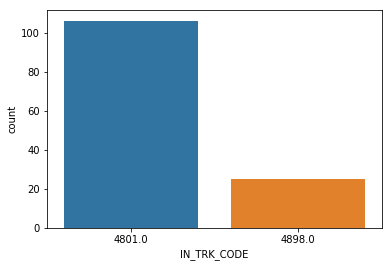

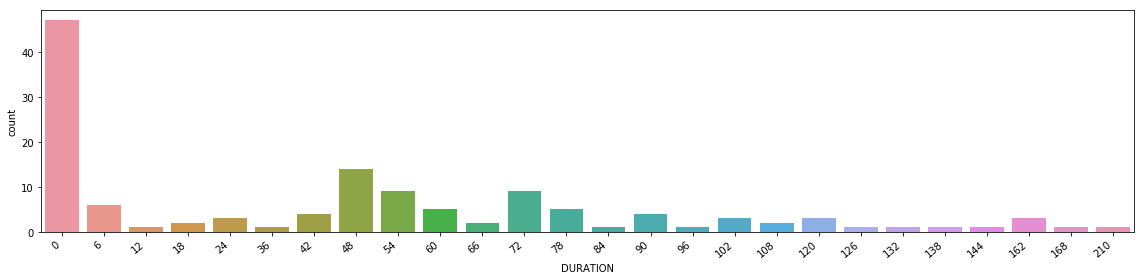

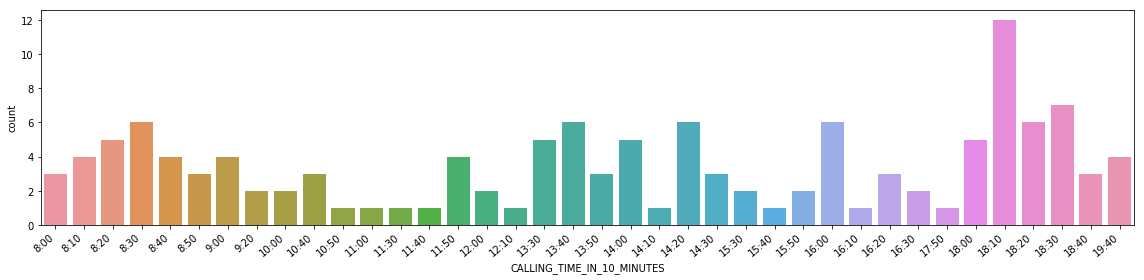

In [118]:
#移动可疑号码 1
df_1 = df[df['CALLING_NUM'] == 18703830954]

sns.countplot(x="IN_TRK_CODE", data=df_1)

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_10_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME_IN_10_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()


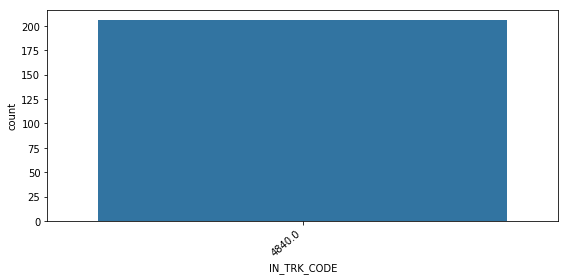

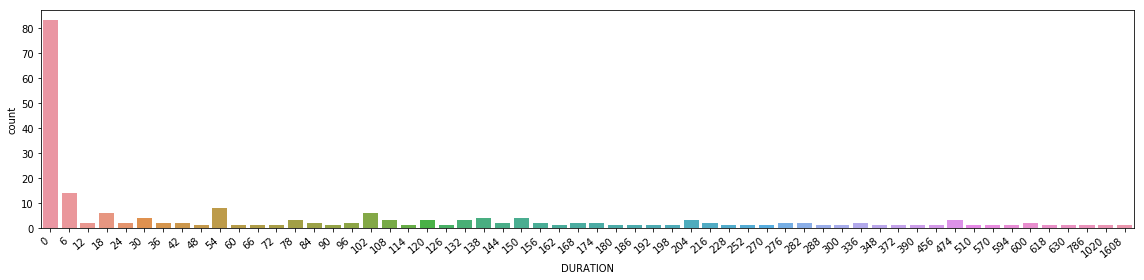

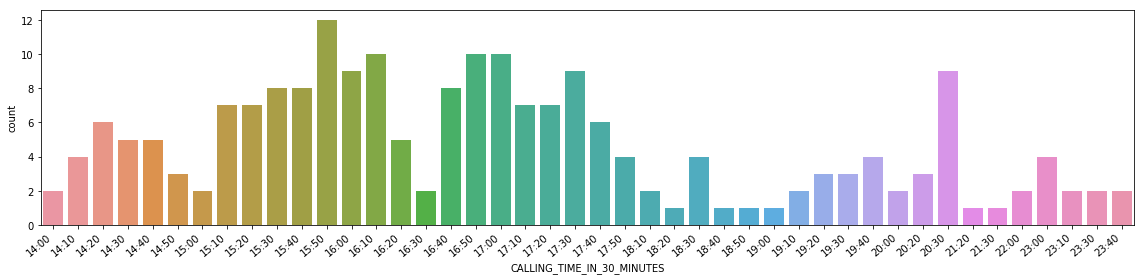

In [141]:
#其他可疑号码 2

#df_1 = df[df['CALLING_NUM'] == 53285763392]
#df_1 = df[df['CALLING_NUM'] == 5305696229]
#df_1 = df[df['CALLING_NUM'] == 82915319]
#df_1 = df[df['CALLING_NUM'] == 6317381531]
#df_1 = df[df['CALLING_NUM'] == 37160959885]
#df_1 = df[df['CALLING_NUM'] == 190852203]
#df_1 = df[df['CALLING_NUM'] == 3127501261]
#df_1 = df[df['CALLING_NUM'] == 41183604731]
df_1 = df[df['CALLING_NUM'] == 28555222]

plt.pyplot.figure(figsize=(8,4))
ax = sns.countplot(x="IN_TRK_CODE", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_30_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME_IN_30_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

### 9. 集中一段时间内频繁拨打电话，通话时间短
一天内某个时间段集中频繁拨打电话，且通话时间极短。比如半小时内通话80次，30+次通话0秒，40+次通话12秒

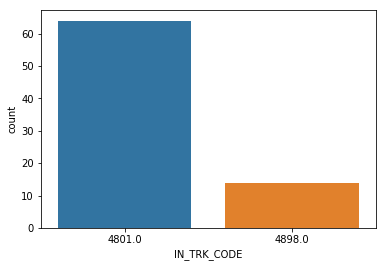

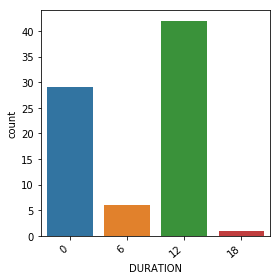

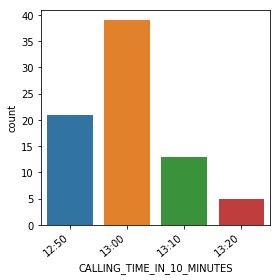

In [127]:
#移动可疑号码 2
df_1 = df[df['CALLING_NUM'] == 18638167274]

sns.countplot(x="IN_TRK_CODE", data=df_1)

plt.pyplot.figure(figsize=(4,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_10_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(4,4))
ax = sns.countplot(x="CALLING_TIME_IN_10_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

### 10. 可疑电话组
一组可疑电话行为模式相似，且号码貌似有规律。比如一组联通号码（6个），每个号码都集中一段时间内频繁拨打电话（时间重叠或错开），通话时间短，号码都是“186973”或者“186381”开头。

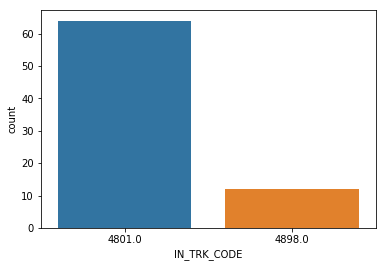

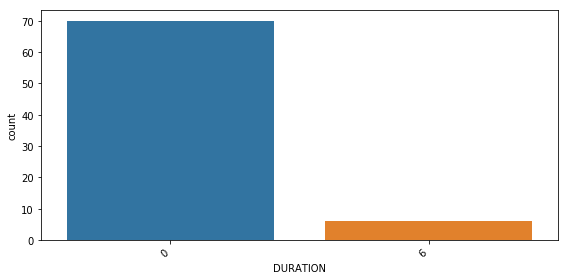

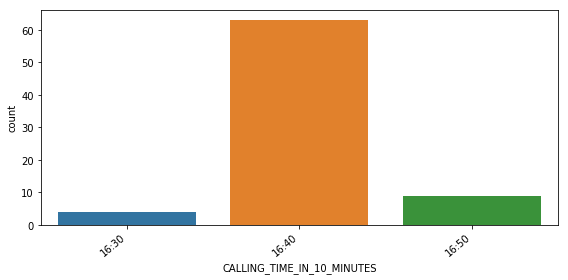

In [138]:
# 联通可疑号码 group
#df_1 = df[df['CALLING_NUM'] == 18697333574]
df_1 = df[df['CALLING_NUM'] == 18697332094]
#df_1 = df[df['CALLING_NUM'] == 18697323604]
#df_1 = df[df['CALLING_NUM'] == 18638175094]
#df_1 = df[df['CALLING_NUM'] == 18638167274]
#df_1 = df[df['CALLING_NUM'] == 18695830824]

sns.countplot(x="IN_TRK_CODE", data=df_1)

plt.pyplot.figure(figsize=(8,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_10_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(8,4))
ax = sns.countplot(x="CALLING_TIME_IN_10_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

### 11. 同一号码频繁访问不同地域中继
电信某号码一天拨打电话100次，分别通过18个不同地域中继，如青海，上海，北京，宁夏，青岛，大连，陕西，山西等

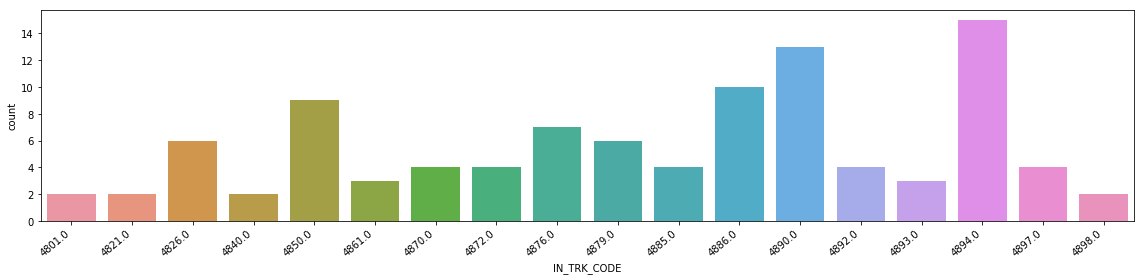

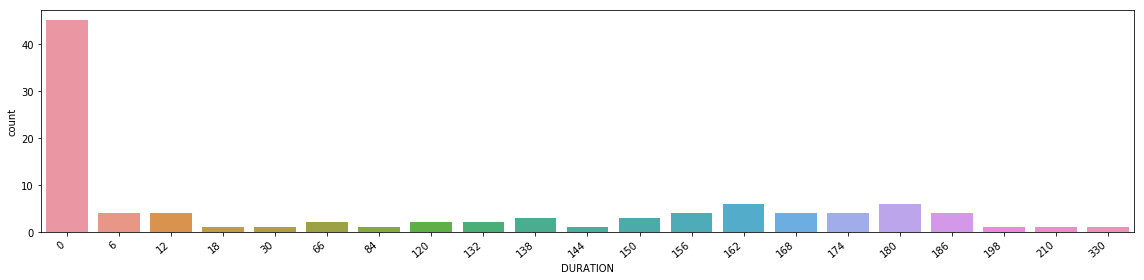

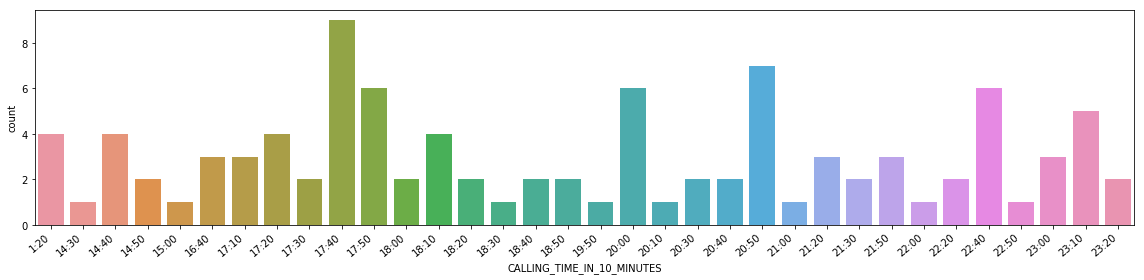

In [139]:
#电信可疑号码
df_1 = df[df['CALLING_NUM'] == 13328108463]

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="IN_TRK_CODE", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df_1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

df1=df_1.sort_values(['CALLING_TIME'])
df1['CALLING_TIME_IN_10_MINUTES'] = df1['CALLING_TIME'].apply(lambda x:str(abs(x)/100) + ":" + str(abs(x)%100/10) + "0" )
plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME_IN_10_MINUTES", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()